### Import Data from apple

In [14]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib as ta
from fredapi import Fred

# Download Apple stock data from its earliest day up to present
apple_data = yf.download('AAPL', start='1970-01-01', end=None)
apple_data.rename(columns={"Adj Close": "AdjClose"}, inplace=True)

# Print the first few rows of the data
print(apple_data.head())
print(apple_data.tail())

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  AdjClose     Volume
Date                                                                   
1980-12-12  0.128348  0.128906  0.128348  0.128348  0.099722  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652  0.094519  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723  0.087582  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513  0.089749   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862  0.092351   73449600
                  Open        High         Low       Close    AdjClose  \
Date                                                                     
2023-03-20  155.070007  157.820007  154.149994  157.399994  157.399994   
2023-03-21  157.320007  159.399994  156.539993  159.279999  159.279999   
2023-03-22  159.300003  162.139999  157.809998  157.830002  157.830002   
2023-03-23  158.830002  161.550003  157.679993  158.92999

In [15]:

# Relative Strength Index (RSI)
apple_data['RSI'] = ta.RSI(apple_data['Close'], timeperiod=14)

# Stochastic Oscillator
apple_data['SOPercentK'], apple_data['SOPercentD'] = ta.STOCH(apple_data['High'], apple_data['Low'], apple_data['Close'])

# Moving Average Convergence Divergence (MACD)
apple_data['MACD'], apple_data['MACDSignal'], apple_data['MACDHistogram'] = ta.MACD(apple_data['Close'])

# Moving Averages
apple_data['SMA50'] = apple_data['Close'].rolling(window=50).mean()
apple_data['SMA200'] = apple_data['Close'].rolling(window=200).mean()

# Bollinger Bands
apple_data['BBUpper'], apple_data['BBMiddle'], apple_data['BBLower'] = ta.BBANDS(apple_data['Close'], timeperiod=20)

# On Balance Volume (OBV)
apple_data['OBV'] = ta.OBV(apple_data['Close'], apple_data['Volume'])

# Chaikin Money Flow (CMF)
period = 20
clv = ((apple_data['Close'] - apple_data['Low']) - (apple_data['High'] - apple_data['Close'])) / (apple_data['High'] - apple_data['Low'])
clv = clv.fillna(0.0)  # Handle NaN
money_flow_volume = clv * apple_data['Volume']
apple_data['CMF'] = money_flow_volume.rolling(window=period).sum() / apple_data['Volume'].rolling(window=period).sum()


In [31]:
stir_data

1954-07-01    0.80
1954-08-01    1.22
1954-09-01    1.07
1954-10-01    0.85
1954-11-01    0.83
              ... 
2022-10-01    3.08
2022-11-01    3.78
2022-12-01    4.10
2023-01-01    4.33
2023-02-01    4.57
Length: 824, dtype: float64

In [16]:
# Get STIR data
fred = Fred(api_key='b788b5f2a26ec3ba6ba6de1559d810da')
stir_data = fred.get_series('FEDFUNDS')

# Convert STIR data to a DataFrame with a DatetimeIndex
stir_df = pd.DataFrame(stir_data, columns=['STIR']).reset_index()
stir_df.rename(columns={'index': 'Date'}, inplace=True)
stir_df['Date'] = pd.to_datetime(stir_df['Date'])

# Resample STIR data to daily frequency and forward-fill missing values
stir_daily = stir_df.set_index('Date').resample('D').ffill()

# Merge STIR daily data with apple_data
apple_data = apple_data.reset_index()
apple_data['Date'] = pd.to_datetime(apple_data['Date'])
merged_data = apple_data.merge(stir_daily, on='Date', how='left')
merged_data = merged_data.set_index('Date')

In [32]:
merged_data.tail()

,Open,High,Low,Close,AdjClose,Volume,RSI,SOPercentK,SOPercentD,MACD,MACDSignal,MACDHistogram,SMA50,SMA200,BBUpper,BBMiddle,BBLower,OBV,CMF,STIR
Date,,,,,,,,,,,,,,,,,,,,
2023-03-20,155.070007,157.820007,154.149994,157.399994,157.399994,73641400,63.411048,89.514298,84.737610,2.131072,1.695590,0.435482,146.6294,147.71605,157.199963,150.6385,144.077037,1.598787e+11,0.007882,NaN
2023-03-21,157.320007,159.399994,156.539993,159.279999,159.279999,73938300,65.969031,91.389926,88.245090,2.477262,1.851925,0.625338,147.2226,147.75640,158.654440,151.1785,143.702561,1.599527e+11,0.102980,NaN
2023-03-22,159.300003,162.139999,157.809998,157.830002,157.830002,75701800,62.348546,84.123338,88.342520,2.604594,2.002458,0.602135,147.7762,147.81865,159.556290,151.6245,143.692711,1.598770e+11,0.034644,NaN
2023-03-23,158.830002,161.550003,157.679993,158.929993,158.929993,67622100,63.964268,72.503786,82.672350,2.762421,2.154451,0.607970,148.3402,147.88260,160.567962,152.1010,143.634039,1.599446e+11,0.002165,NaN
2023-03-24,158.860001,160.339996,157.850006,160.250000,160.250000,59196500,65.857700,65.040861,73.889328,2.959895,2.315540,0.644355,148.8754,147.94030,161.571452,152.7780,143.984548,1.600038e+11,0.028629,NaN


In [5]:
# merged_data = merged_data.reset_index(drop=False)

### 导入数据库

In [23]:
import pymysql

# Connect to the MySQL database
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='1234',
    database='stock_data_db'
)
table_name = 'merged_data_table'


# Create a table in the database
cursor = connection.cursor()
create_table_query = f'''
CREATE TABLE IF NOT EXISTS {table_name} (
    Date DATE,
    Open FLOAT,
    High FLOAT,
    Low FLOAT,
    Close FLOAT,
    AdjClose FLOAT,
    Volume BIGINT,
    RSI FLOAT,
    SOPercentK FLOAT,
    SOPercentD FLOAT,
    MACD FLOAT,
    MACDSignal FLOAT,
    MACDHistogram FLOAT,
    SMA50 FLOAT,
    SMA200 FLOAT,
    BBUpper FLOAT,
    BBMiddle FLOAT,
    BBLower FLOAT,
    OBV FLOAT,
    CMF FLOAT,
    STIR FLOAT
)
'''
cursor.execute(create_table_query)
connection.commit()


In [19]:

# Insert merged_data into the table
for index, row in merged_data.reset_index().iterrows():
    # Replace NaN values with None for inserting NULL into the database
    row = row.where(pd.notnull(row), None)
    
    insert_query = f'''
    INSERT INTO merged_data_table (Date, Open, High, Low, Close, AdjClose, Volume, RSI, SOPercentK, SOPercentD, MACD, MACDSignal, MACDHistogram, SMA50, SMA200, BBUpper, BBMiddle, BBLower, OBV, CMF, STIR)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE
        Open = VALUES(Open),
        High = VALUES(High),
        Low = VALUES(Low),
        Close = VALUES(Close),
        AdjClose = VALUES(AdjClose),
        Volume = VALUES(Volume),
        RSI = VALUES(RSI),
        SOPercentK = VALUES(SOPercentK),
        SOPercentD = VALUES(SOPercentD),
        MACD = VALUES(MACD),
        MACDSignal = VALUES(MACDSignal),
        MACDHistogram = VALUES(MACDHistogram),
        SMA50 = VALUES(SMA50),
        SMA200 = VALUES(SMA200),
        BBUpper = VALUES(BBUpper),
        BBMiddle = VALUES(BBMiddle),
        BBLower = VALUES(BBLower),
        OBV = VALUES(OBV),
        CMF = VALUES(CMF),
        STIR = VALUES(STIR);
    '''
    cursor.execute(insert_query, tuple(row))
    connection.commit()



In [28]:
# Close the connection
cursor.close()
connection.close()

Error: Already closed

### 绘制图像

C:\Users\SHU\AppData\Local\Temp\ipykernel_24016\2789671493.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  stock_data = pd.read_sql(select_data_query, connection)
C:\Users\SHU\anaconda3\envs\quant\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


TypeError: kwarg "type" validator returned False for value: "bar"
    'Validator'   : lambda value: value in _get_valid_plot_types() },

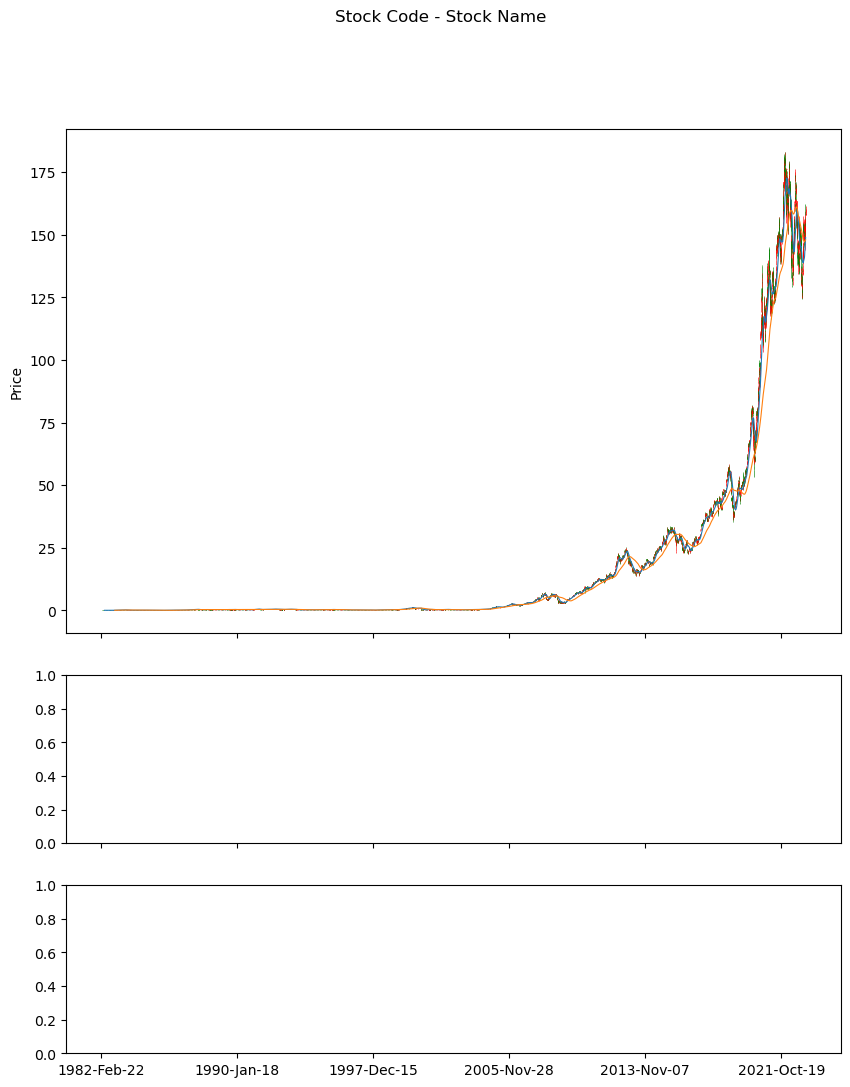

In [30]:
import mplfinance as mpf
from matplotlib.backend_bases import MouseButton
import pandas as pd
import pymysql
import matplotlib.pyplot as plt

# ... 保留原有的数据库连接和数据处理部分 ...
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='1234',
    database='stock_data_db'
)
table_name = 'merged_data_table'

# Get stock data from the database
select_data_query = f"SELECT * FROM {table_name}"
stock_data = pd.read_sql(select_data_query, connection)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.set_index('Date', inplace=True)

# 定义颜色方案
mc = mpf.make_marketcolors(up='red', down='green', inherit=True)
s = mpf.make_mpf_style(marketcolors=mc)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12), gridspec_kw={'height_ratios': [3, 1, 1]})
fig.subplots_adjust(hspace=0.15)
fig.suptitle('Stock Code - Stock Name')

# 删除前300行数据
stock_data = stock_data.iloc[300:]

# 绘制K线图与移动平均线
mpf.plot(stock_data, type='candle', mav=(50, 200), ax=axes[0], style=s, ylabel='Price')
#
# 绘制交易量
mpf.plot(stock_data, type='bar', ax=axes[1], style=s, ylabel='Volume', volume=True)
#
# # 绘制MACD指标
# ap_macd = [mpf.make_addplot(stock_data[['MACD', 'MACDSignal']], panel=2, ylabel='MACD')]
# mpf.plot(stock_data, ax=axes[2], style=s, addplot=ap_macd)
#
# # 移动K线图的功能
# def on_click(event):
#     if event.button == MouseButton.LEFT:
#         # 可以在此添加实现单击拖动平移K线图的代码
#
#         # 您可以尝试使用 mplfinance 的内置 pan 和 zoom 操作，但它可能不支持所有您需要的操作。在这种情况下，可以尝试自定义代码。
#         pass
#
#     elif event.button == MouseButton.RIGHT:
#         # 缩放K线图
#         if event.key == "up":
#             # 放大K线图
#             pass
#         elif event.key == "down":
#             # 缩小K线图
#             pass
#
# fig.canvas.mpl_connect('button_press_event', on_click)
#
# # 双击事件处理函数
# def on_double_click(event):
#     global current_indicator
#     if event.dblclick:
#         if event.inaxes == axes[0]:
#             # 在此添加实现双击切换移动平均线和布林带线的代码
#             pass
#         elif event.inaxes == axes[2]:
#             # 在此添加实现双击切换不同指标类型（如MACD/DEMA/RSI）的代码
#             pass
#
# fig.canvas.mpl_connect('button_press_event', on_double_click)

plt.show()


### Data Preparation: Load Data to SQL

In [18]:
import pymysql
from nsepy import get_history
from datetime import datetime

# Define the database connection parameters
host = 'localhost'
user = 'root'
password = '1234'
database = 'stock_data_db'

# Define the stock data retrieval parameters
symbol = 'INFY'
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 2, 10)

# Connect to the database
conn = pymysql.connect(host=host, user=user, password=password, database=database)
cursor = conn.cursor()

# Define the SQL query to create the table
create_table_query = """CREATE TABLE IF NOT EXISTS stock_data_basic (
                        Symbol varchar(10),
                        Series varchar(10),
                        Date date,
                        Prev_Close float(15,2),
                        Open float(15,2),
                        High float(15,2),
                        Low float(15,2),
                        Last float(15,2),
                        Close float(15,2),
                        VWAP float(15,2),
                        Volume int(15),
                        Turnover float(20,2),
                        Trades int(15),
                        Deliverable_Volume int(15),
                        Percent_Deliverable float(15,2)
                        )"""

# Execute the SQL query to create the table
cursor.execute(create_table_query)

# Commit the changes to the database
conn.commit()

# Retrieve the stock data
data = get_history(symbol=symbol, start=start_date, end=end_date)

# Insert the stock data into the table
for index, row in data.iterrows():
    insert_query = f"""INSERT INTO stock_data_basic (Symbol, Series, Date, Prev_Close, Open, High, Low, Last, Close, VWAP, Volume, Turnover, Trades, Deliverable_Volume, Percent_Deliverable)
                        VALUES ('{symbol}', '{row['Series']}', '{index}', {row['Prev Close']}, {row['Open']}, {row['High']}, {row['Low']}, {row['Last']}, {row['Close']}, {row['VWAP']}, {row['Volume']}, {row['Turnover']}, {row['Trades']}, {row['Deliverable Volume']}, {row['%Deliverble']})"""
    cursor.execute(insert_query)

# Commit the changes to the database
conn.commit()
conn.close()
# Close the database connection

### Create Indicator Table

In [2]:
import pymysql
from nsepy import get_history
from datetime import datetime
import talib

# Define the database connection parameters
host = 'localhost'
user = 'root'
password = '1234'
database = 'stock_data_db'

# Define the stock data retrieval parameters
symbol = 'INFY'
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 2, 10)

In [3]:
# Define the discrete values for the indicators
short_term_interest_rate_discrete = {'low': 0.0, 'medium': 0.5, 'high': 1.0}
put_call_ratio_discrete = {'low': 0.0, 'medium': 0.5, 'high': 1.0}
volatility_index_discrete = {'low': 0.0, 'medium': 0.5, 'high': 1.0}
rsi_discrete = {'oversold': 0.0, 'neutral': 0.5, 'overbought': 1.0}
stoch_discrete = {'oversold': 0.0, 'neutral': 0.5, 'overbought': 1.0}
macd_discrete = {'bearish': 0.0, 'neutral': 0.5, 'bullish': 1.0}
ma_discrete = {'below': 0.0, 'neutral': 0.5, 'above': 1.0}
bb_discrete = {'below_lower': 0.0, 'within_bands': 0.5, 'above_upper': 1.0}
obv_discrete = {'bearish': 0.0, 'neutral': 0.5, 'bullish': 1.0}
#cmf_discrete = {'bearish': 0.0, 'neutral': 0.5, 'bullish': 1.0}

# Connect to the database
conn = pymysql.connect(host=host, user=user, password=password, database=database)
cursor = conn.cursor()

# Define the SQL query to create the table
create_table_query = """CREATE TABLE IF NOT EXISTS stock_data_indicators (
                        Symbol varchar(10),
                        Series varchar(10),
                        Date date,
                        Prev_Close float(15,2),
                        Open float(15,2),
                        High float(15,2),
                        Low float(15,2),
                        Last float(15,2),
                        Close float(15,2),
                        VWAP float(15,2),
                        Volume int(15),
                        Turnover float(20,2),
                        Trades int(15),
                        Deliverable_Volume int(15),
                        Percent_Deliverable float(15,2),
                        STIR_discrete float(3,2),
                        PCR_discrete float(3,2),
                        VI_discrete float(3,2),
                        RSI_discrete float(3,2),
                        STOCH_discrete float(3,2),
                        MACD_discrete float(3,2),
                        MA_discrete float(3,2),
                        BB_discrete float(3,2),
                        OBV_discrete float(3,2),
                        CMF_discrete float(3,2),
                        Decision varchar(10),
                        CDL2CROWS INT, CDL3BLACKCROWS INT, CDL3INSIDE INT, CDL3LINESTRIKE INT, CDL3OUTSIDE INT, CDL3STARSINSOUTH INT, CDL3WHITESOLDIERS INT, CDLABANDONEDBABY INT, CDLADVANCEBLOCK INT, CDLBELTHOLD INT, CDLBREAKAWAY INT, CDLCLOSINGMARUBOZU INT, CDLCONCEALBABYSWALL INT, CDLCOUNTERATTACK INT, CDLDARKCLOUDCOVER INT, CDLDOJI INT, CDLDOJISTAR INT, CDLDRAGONFLYDOJI INT
                        )"""

# Execute the SQL query to create the table
cursor.execute(create_table_query)

# Commit the changes to the database
conn.commit()
conn.close()
# Retrieve the stock data

### All indicators

In [162]:
data = get_history(symbol=symbol, start=start_date, end=end_date)

In [165]:
# Calculate in
# dicators using talib
data['STIR'] = talib.RSI(data['Close'], timeperiod=14)
data['PCR'] = data['Volume'].rolling(window=10).sum() / data['Volume'].rolling(window=10).mean()
data['VI'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
data['slowk'], data['slowd'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
data['MACD'], data['MACDsignal'], data['MACDhist'] = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['MA5'] = talib.MA(data['Close'], timeperiod=5)
data['MA10'] = talib.MA(data['Close'], timeperiod=10)
data['MA20'] = talib.MA(data['Close'], timeperiod=20)
data['MA50'] = talib.MA(data['Close'], timeperiod=50)
data['MA200'] = talib.MA(data['Close'], timeperiod=200)
upperband, middleband, lowerband = talib.BBANDS(data['Close'], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
data['BB'] = (data['Close'] - lowerband) / (upperband - lowerband)
data['OBV'] = talib.OBV(data['Close'], data['Volume'])
# data['CMF'] = talib.CMF(data['High'], data['Low'], data['Close'], data['Volume'], timeperiod=20)
# Calculate Chaikin A/D Oscillator
data['ADOSC'] = talib.ADOSC(data['High'], data['Low'], data['Close'], data['Volume'], fastperiod=3, slowperiod=10)
# Discretize the indicator values
data['STIR_discrete'] = pd.cut(data['STIR'], bins=[0, 30, 70, 100], labels=['low', 'medium', 'high'])
data['PCR_discrete'] = pd.cut(data['PCR'], bins=[0, 0.8, 1.2, 100], labels=['low', 'medium', 'high'])
data['VI_discrete'] = pd.cut(data['VI'], bins=[0, 10, 20, 1000], labels=['low', 'medium', 'high'])
data['RSI_discrete'] = pd.cut(data['RSI'], bins=[0, 30, 70, 100], labels=['oversold', 'neutral', 'overbought'])
data['STOCH_discrete'] = pd.cut(data['slowd'], bins=[0, 20, 80, 100], labels=['oversold', 'neutral', 'overbought'])
data['MACD_discrete'] = pd.cut(data['MACDhist'], bins=[-1000, 0, 1000], labels=['bearish', 'bullish'])
# Define the discrete values for the CMF indicator
cmf_discrete = {'bearish': 0.0, 'neutral': 0.5, 'bullish': 1.0}

# Apply the discrete values to the CMF indicator
data['CMF_discrete'] = data['ADOSC'].apply(lambda x: cmf_discrete['bearish'] if x < 0 else cmf_discrete['bullish'] if x > 0 else cmf_discrete['neutral'])
# Calculate moving average (MA)
data['MA'] = talib.SMA(data['Close'], timeperiod=20)

# Calculate upper and lower Bollinger Bands (BB)
data['upper'], data['middle'], data['lower'] = talib.BBANDS(data['Close'], timeperiod=20)

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Close'], data['Volume'])

# Define the function to discretize the indicators
def discretize(value, thresholds):
    if value < thresholds['low']:
        return 0.0
    elif value < thresholds['high']:
        return 0.5
    else:
        return 1.0

# Discretize the indicators
data['MA_discrete'] = data['Close'].rolling(window=20).apply(lambda x: discretize(x[-1], {'low': data['MA'].min(), 'high': data['MA'].max()}))
data['BB_discrete'] = data['Close'].rolling(window=20).apply(lambda x: discretize(x[-1], {'low': data['lower'].min(), 'high': data['upper'].max()}))
data['OBV_discrete'] = data['OBV'].rolling(window=20).apply(lambda x: discretize(x[-1], {'low': data['OBV'].min(), 'high': data['OBV'].max()}))
data['CDL2CROWS'] = talib.CDL2CROWS(data['Open'], data['High'], data['Low'], data['Close'])
data['CDL3BLACKCROWS'] = talib.CDL3BLACKCROWS(data['Open'], data['High'], data['Low'], data['Close'])
data['CDL3INSIDE'] = talib.CDL3INSIDE(data['Open'], data['High'], data['Low'], data['Close'])
data['CDL3LINESTRIKE'] = talib.CDL3LINESTRIKE(data['Open'], data['High'], data['Low'], data['Close'])
data['CDL3OUTSIDE'] = talib.CDL3OUTSIDE(data['Open'], data['High'], data['Low'], data['Close'])
data['CDL3STARSINSOUTH'] = talib.CDL3STARSINSOUTH(data['Open'], data['High'], data['Low'], data['Close'])
data['CDL3WHITESOLDIERS'] = talib.CDL3WHITESOLDIERS(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLABANDONEDBABY'] = talib.CDLABANDONEDBABY(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLADVANCEBLOCK'] = talib.CDLADVANCEBLOCK(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLBELTHOLD'] = talib.CDLBELTHOLD(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLBREAKAWAY'] = talib.CDLBREAKAWAY(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLCLOSINGMARUBOZU'] = talib.CDLCLOSINGMARUBOZU(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLCONCEALBABYSWALL'] = talib.CDLCONCEALBABYSWALL(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLCOUNTERATTACK'] = talib.CDLCOUNTERATTACK(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLDARKCLOUDCOVER'] = talib.CDLDARKCLOUDCOVER(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLDOJI'] = talib.CDLDOJI(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLDOJISTAR'] = talib.CDLDOJISTAR(data['Open'], data['High'], data['Low'], data['Close'])
data['CDLDRAGONFLYDOJI'] = talib.CDLDRAGONFLYDOJI(data['Open'], data['High'], data['Low'], data['Close'])

In [170]:
data = data.reset_index(drop=False)

In [171]:
data.columns = data.columns.str.replace(' ', '_') # replace blank spaces with underscores

In [172]:
data.columns = data.columns.str.replace('%', 'Percent_')

In [213]:
specific_date = datetime(2019,1,1).date() # example date

In [240]:
mount_price = data[data['Date'] == specific_date]['Close'][0]

In [241]:
data['Decision'] = data.apply(lambda x: 'Sell' if x['Close'] > mount_price
                                      else ('Buy' if x['Close'] < mount_price
                                            else 'Hold'), axis=1)

In [249]:
import pandas as pd
import pymysql

# create connection to MySQL server
conn = pymysql.connect(host="localhost", user="root", password="1234", database="stock_data_db")

data['Date'] = pd.to_datetime(data['Date'])

# get column names and data types
cols = data.columns
types = data.dtypes

# map pandas data types to MySQL data types
sql_types = []
for t in types:
    if t == "object":
        sql_types.append("varchar(255)")
    elif t == "int64" or t == "int32":
        sql_types.append("int(128)")
    elif t == "float64":
        sql_types.append("float(128,30)")
    elif t == "datetime64[ns]":
        sql_types.append("date")
    elif t.name == "category":
        sql_types.append("varchar(255)")

In [251]:
# create SQL statement to create table
table_name = "stock_data_test"
sql_cols = []
for i in range(len(cols)):
    sql_cols.append(f"{cols[i]} {sql_types[i]}")
sql_cols_str = ",".join(sql_cols)

In [252]:
sql = f"CREATE TABLE IF NOT EXISTS {table_name} ({sql_cols_str}, PRIMARY KEY ({cols[0]}))"

In [254]:
# execute SQL statement to create table
cur = conn.cursor()
cur.execute(sql)

0

In [255]:
columns = []
for col in data.columns:
    col_name = col.strip()
    columns.append(f'{col_name}')
f'({", ".join(columns)})'

# Insert data into MySQL table
for index, row in data.iterrows():
    values = []
    for value, col_type in zip(row, data.dtypes):
        if str(value) == 'nan':
            values.append('NULL')
        else:
            if col_type.name == 'category':
                #values.append(str(value))
                values.append('\''+str(value)+'\'')
            elif col_type == 'datetime64[ns]':
                values.append('\''+value.strftime('%Y-%m-%d')+'\'')
            elif col_type == 'object':
                values.append('\''+str(value)+'\'')
            else:
                #values.append(value)
                values.append('\''+str(value)+'\'')
    values_str = ', '.join([str(x) for x in values])
    sql = f"""INSERT INTO {table_name} ({", ".join(columns)}) VALUES ({values_str})"""
    with conn.cursor() as cursor:
        cursor.execute(sql)

INSERT INTO stock_data_test (Date, Symbol, Series, Prev_Close, Open, High, Low, Last, Close, VWAP, Volume, Turnover, Trades, Deliverable_Volume, Percent_Deliverble, STIR, PCR, VI, RSI, slowk, slowd, MACD, MACDsignal, MACDhist, MA5, MA10, MA20, MA50, MA200, BB, OBV, ADOSC, STIR_discrete, PCR_discrete, VI_discrete, RSI_discrete, STOCH_discrete, MACD_discrete, CMF_discrete, MA, upper, middle, lower, MA_discrete, BB_discrete, OBV_discrete, CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, Decision) VALUES ('2019-01-01', 'INFY', 'EQ', '658.95', '660.95', '666.3', '654.15', '665.95', '665.05', '660.66', '2943390', '194457942255000.0', '45422', '1282161', '0.43560000000000004', NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, NULL, N

In [256]:
conn.commit()

In [257]:
conn.close()